# Earthquake Damage Grade Prediction
---

The goal of our project is to predict the damage level that an earthquake can cause on a specific building given its features. We rely on the Nepal's earthquake dataset available on kaggle: https://www.kaggle.com/datasets/mullerismail/richters-predictor-modeling-earthquake-damage?select=train_values.csv 


## Importing the Libraries
We start by importing the necessary libraries that we will use in this project

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier,  HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
import warnings 
import missingno as msno
import scipy.stats as stats
from scipy.stats import chi2_contingency
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

## Getting the data
We have the features and the labels separated, so we load them into 2 dataframes: features and labels, and then we combine both of them in one dataframe, df.

In [ ]:
features = pd.read_csv('train_values.csv')
labels = pd.read_csv('train_labels.csv')

df = pd.concat([features, labels['damage_grade']], axis=1)
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


## Exploratory Data Analysis (EDA)
We start by investigating our data and analyzing it, so that we can benefit from this analysis in later parts.

#### Data Shape
We check the number of rows and columns in the dataset

In [ ]:
n_rows, n_cols = df.shape

print(f"this dataset has {n_rows} rows and {n_cols} columns")

this dataset has 260601 rows and 40 columns


#### Data Types
We check the data type of each column in the dataset

In [ ]:
df.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

#### Summary Statistics
We get some summary statistics for the numerical variables

In [ ]:
df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,...,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,...,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


We do the same for categorical variables

In [ ]:
df.describe(include='O')

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
count,260601,260601,260601,260601,260601,260601,260601,260601
unique,3,5,3,5,4,4,10,4
top,t,r,n,f,q,s,d,v
freq,216757,219196,182842,209619,165282,202090,250072,250939


#### Checking for Null values

In [ ]:
print(df.isnull().sum())

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

**We have no null values inside of the dataset**

#### Checking for duplicates

In [ ]:
df.duplicated().sum()

0

**We do not have duplicated rows**

#### Exploring the target variable
We need to see the distribution of the target variable (damage grade) that our goal is to predict based on the features we have.

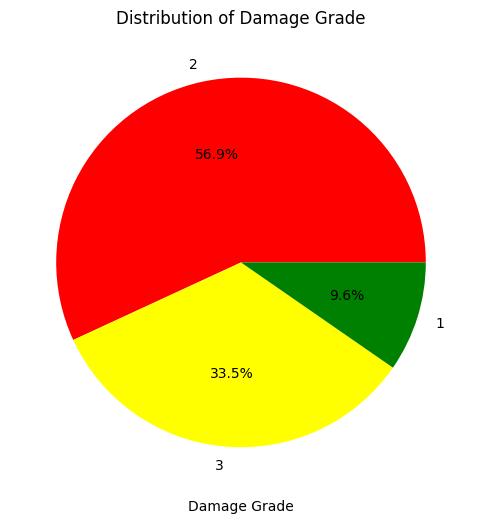

In [ ]:
# Calculate the percentage of each class
class_counts = df['damage_grade'].value_counts(normalize=True) * 100

# Visualize the distribution
plt.figure(figsize=(8, 6))
ax = class_counts.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'yellow', 'green'])
plt.xlabel('Damage Grade')
plt.ylabel('')

plt.title('Distribution of Damage Grade')

plt.show()

**We can see that there is an imbalance in the dataset as each category has a different percentage. Later on, we will try to deal with this matter.**

#### Studying Correlations
We need to study correlations between our features and the target variable. To study correlations with the target, we can compute the **correlation matrix** that shows **Pearson's correlation**. This correlation matrix shows correlation only for variables that have numerical types (int, float, etc.). We will do something else observe correlation with other variables.

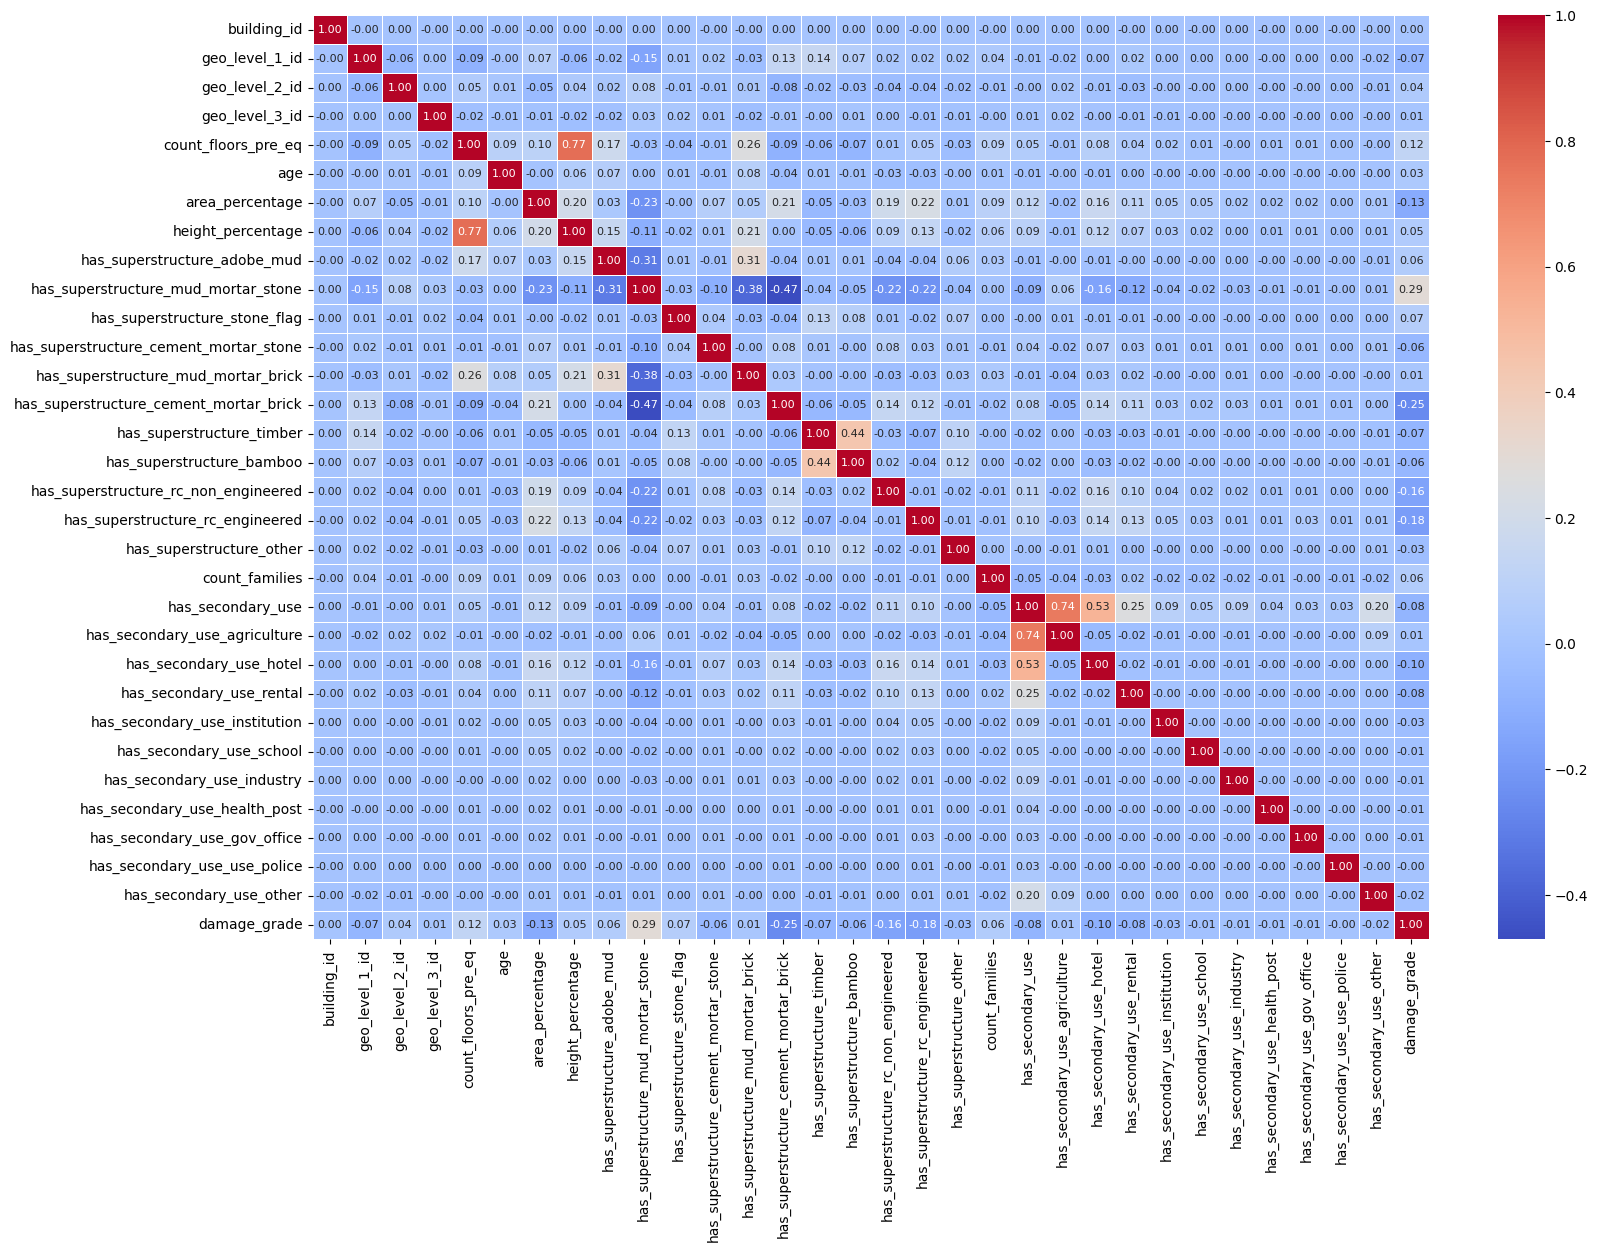

In [ ]:
# Compute correlation matrix
num_vars = ['count_families', 'area_percentage', 'height_percentage', 'age', 'count_floors_pre_eq', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
corr_matrix = df.corr()

# Set figure size
fig, ax = plt.subplots(figsize=(18, 12))

# Plot correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, ax=ax, annot_kws={"fontsize":8})
plt.show()

**The good thing about this heatmap is that is measures correlation by numbers and it shows that the area, the number of floors, and some superstructure features are correlated with the target. In the next cells, we will study the correlation in a more visual way.**

##### Numerical Features

Another way to reflect on whether a variable is correlated with a categorical variable is to plot its distribution with respect to each category. If the distributions are the same, then there is no correlation. This is what we do next with the numerical features.

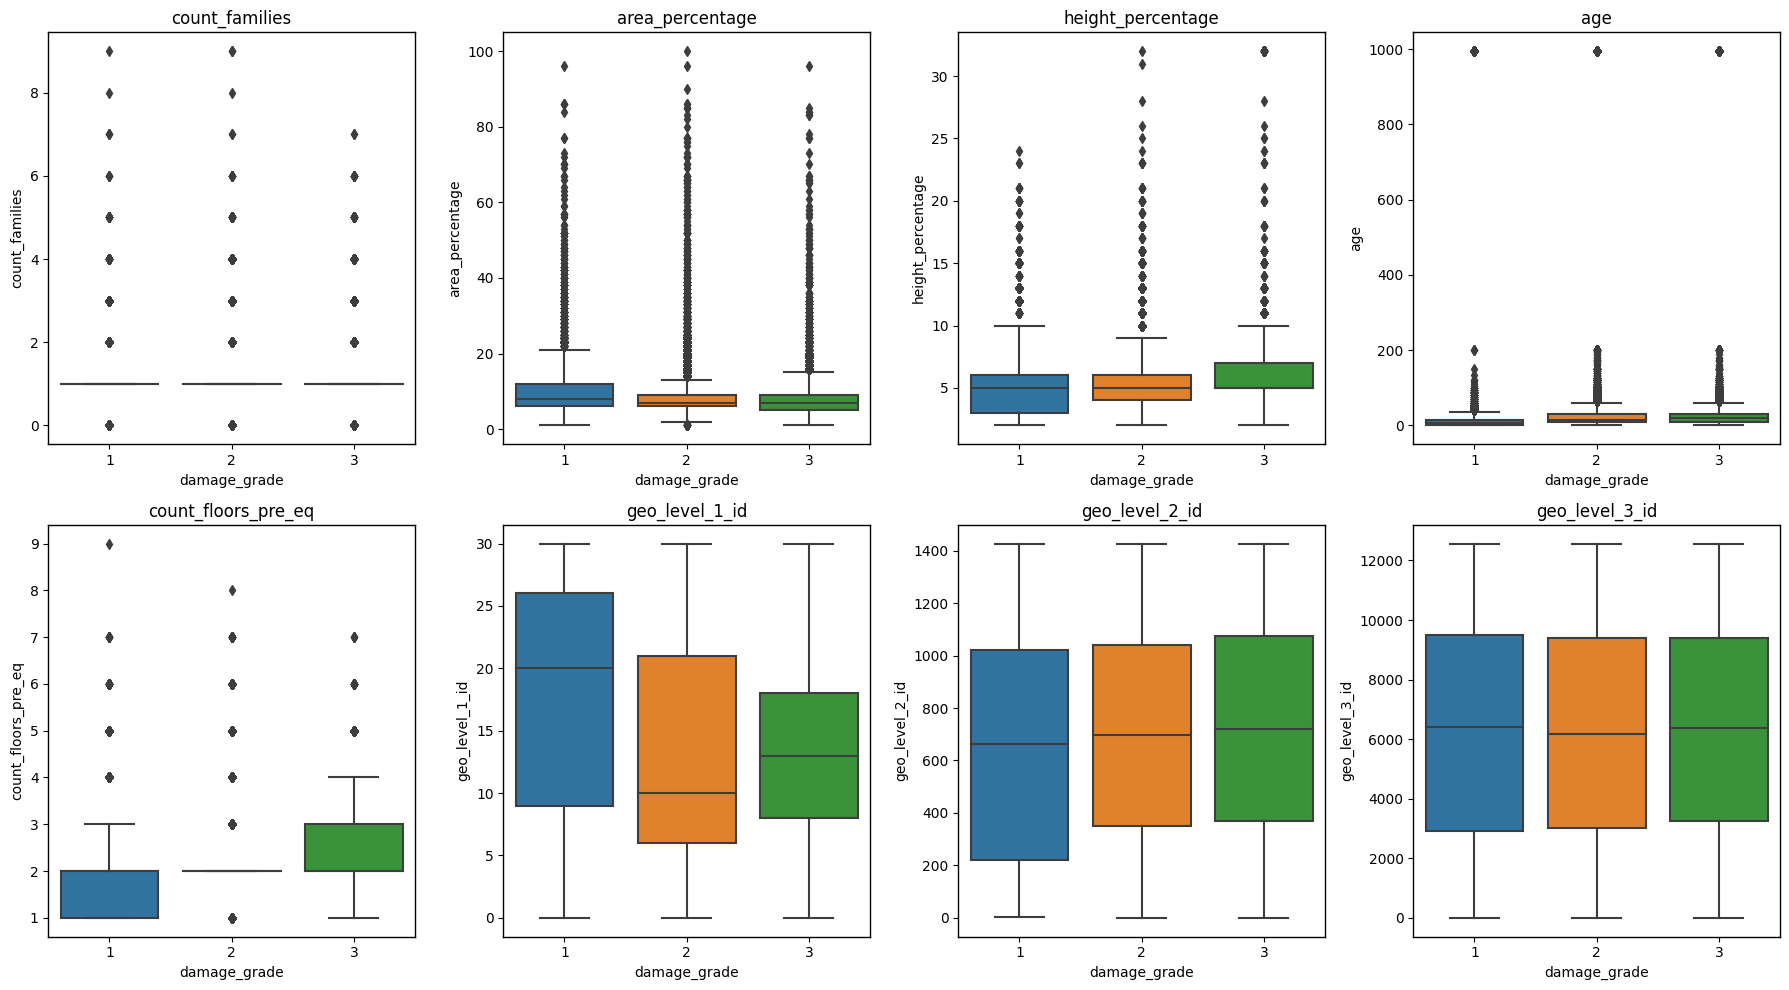

In [ ]:
num_vars = ['count_families', 'area_percentage', 'height_percentage', 'age', 'count_floors_pre_eq', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
target_var = 'damage_grade'

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))

for i, num_var in enumerate(num_vars):
    row = i // 4  # Calculate the row index
    col = i % 4   # Calculate the column index
    
    ax = sns.boxplot(x=target_var, y=num_var, data=df, ax=axs[row, col])
    ax.set_title(num_var)
    ax.set_facecolor('none')

    # Draw a frame around the subplot
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')

plt.tight_layout()
plt.show()

**We can see that the "count families" feature is not changing distribution which means that it does not affect the target variable. Therefore, we will remove it later on.**

##### Categorical Features
This dataset contains many categorical features. For easier readability, we will group the features in 3 groups, and visualize in each cell one group of features. We will use a similar approach where we show the distribution of the feature with respect to each value of the target variable and see if the proportions change. In that case, the variables will be correlated.

**We define a helper function to plot subplots, and we use it for each group instead of repeating the same code.**

In [ ]:
def plot_correlation_cat_features(num_rows, num_cols, binary_vars, target_var):
  # Create the plot grid and initialize the subplot index
  fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 10))
  subplot_index = 0

  # Loop over the binary variables and create a stacked bar chart for each one in a separate subplot
  for binary_var in binary_vars:
      if subplot_index >= num_rows * num_cols:
          break
      row = subplot_index // num_cols
      col = subplot_index % num_cols
      ax = axs[row, col]
      
      # Calculate the count and percentage of each class
      class_counts = df.groupby([binary_var, target_var])[target_var].count().unstack()
      class_percentages = class_counts.div(class_counts.sum(axis=1), axis=0)
      
      # Plot the stacked bar chart with percentage labels
      class_percentages.plot(kind='bar', stacked=True, ax=ax)
      #ax.set_title(binary_var)
      ax.set_ylabel('Percentage')
      
      # Add percentage labels to the bars
      for p in ax.patches:
          width = p.get_width()
          height = p.get_height()
          x, y = p.get_xy()
          ax.annotate(f'{height:.1%}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
      
      # Move the legend to the right side of the plot
      ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      
      subplot_index += 1

  # Adjust the spacing between subplots and display the plot
  plt.subplots_adjust(hspace=0.5, wspace=0.6)
  plt.show()

##### Superstructure Features
In this part we will see if the superstructure features are correlated or not with the target variable.

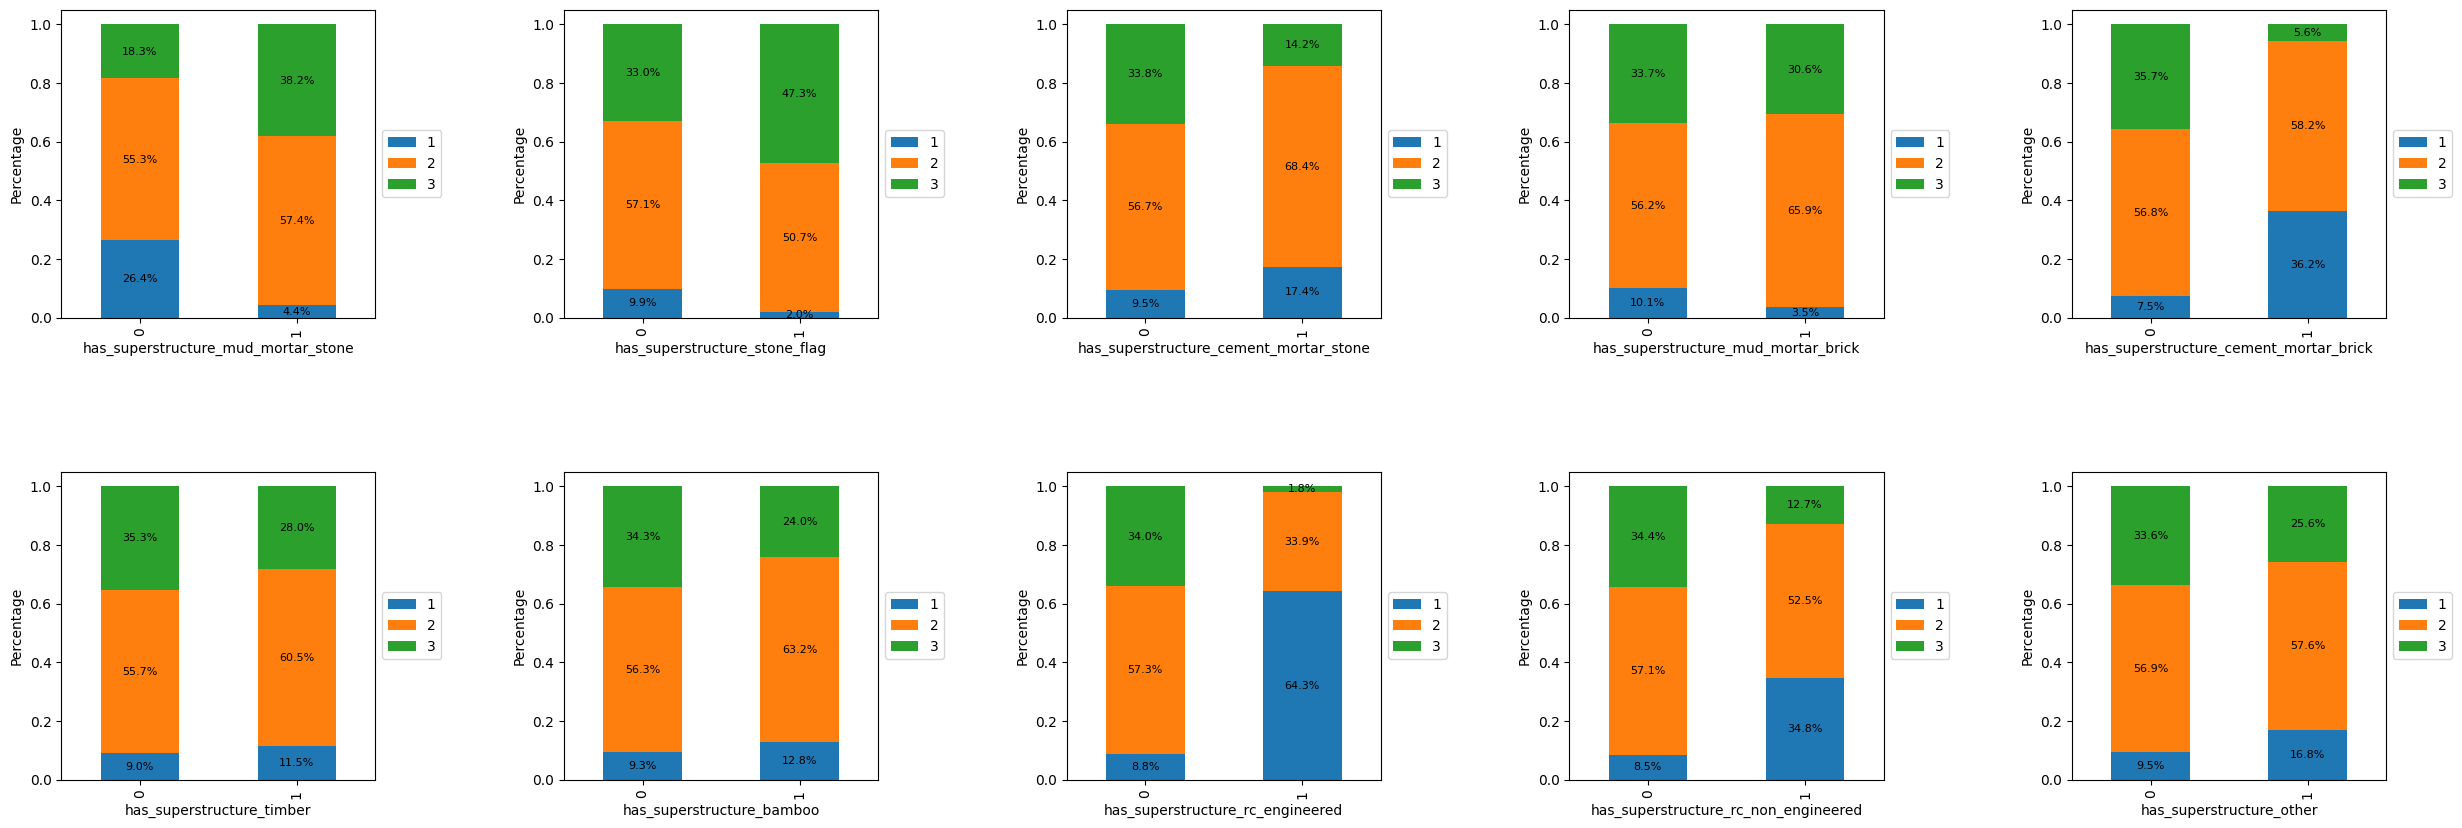

In [ ]:
binary_vars = ['has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 
               'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
               'has_superstructure_bamboo', 'has_superstructure_rc_engineered', 'has_superstructure_rc_non_engineered', 'has_superstructure_other']
target_var = 'damage_grade'

# Set the number of rows and columns for the plot grid
num_rows = 2
num_cols = 5

plot_correlation_cat_features(num_rows, num_cols, binary_vars, target_var)

**From the above charts, we can see that the percentages are really different, indicating a potential relationship between the superstructure variables and the target variable**

##### Secondary User Features
In this part we will see if the secondary use features are correlated or not with the target variable.

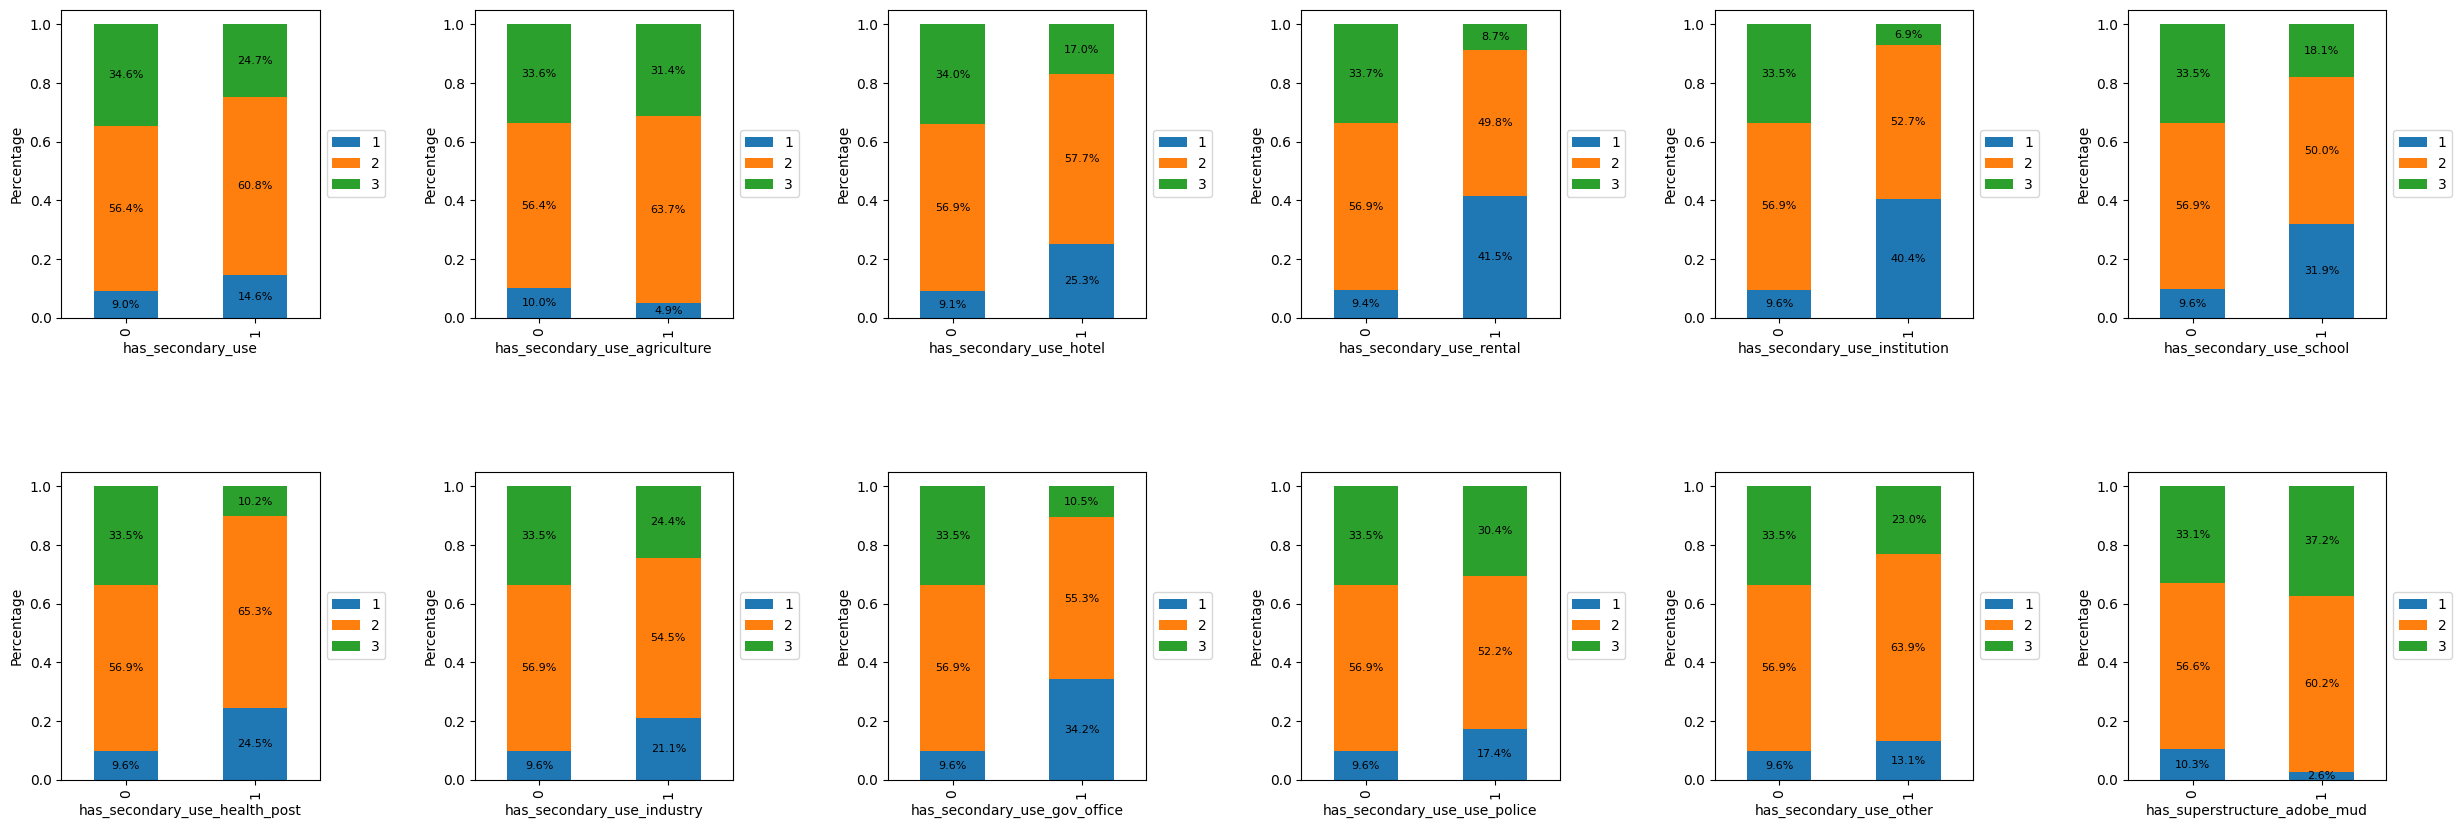

In [ ]:
binary_vars = ['has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 
               'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school',
               'has_secondary_use_health_post', 'has_secondary_use_industry', 'has_secondary_use_gov_office', 
               'has_secondary_use_use_police','has_secondary_use_other','has_superstructure_adobe_mud']
target_var = 'damage_grade'

# Set the number of rows and columns for the plot grid
num_rows = 2
num_cols = 6

plot_correlation_cat_features(num_rows, num_cols, binary_vars, target_var)

**Also here, since the percentages are different, it seems that these features are correlated with the target variable.**

##### Remaining Categorical Features
Now we do the same with the rest of the features

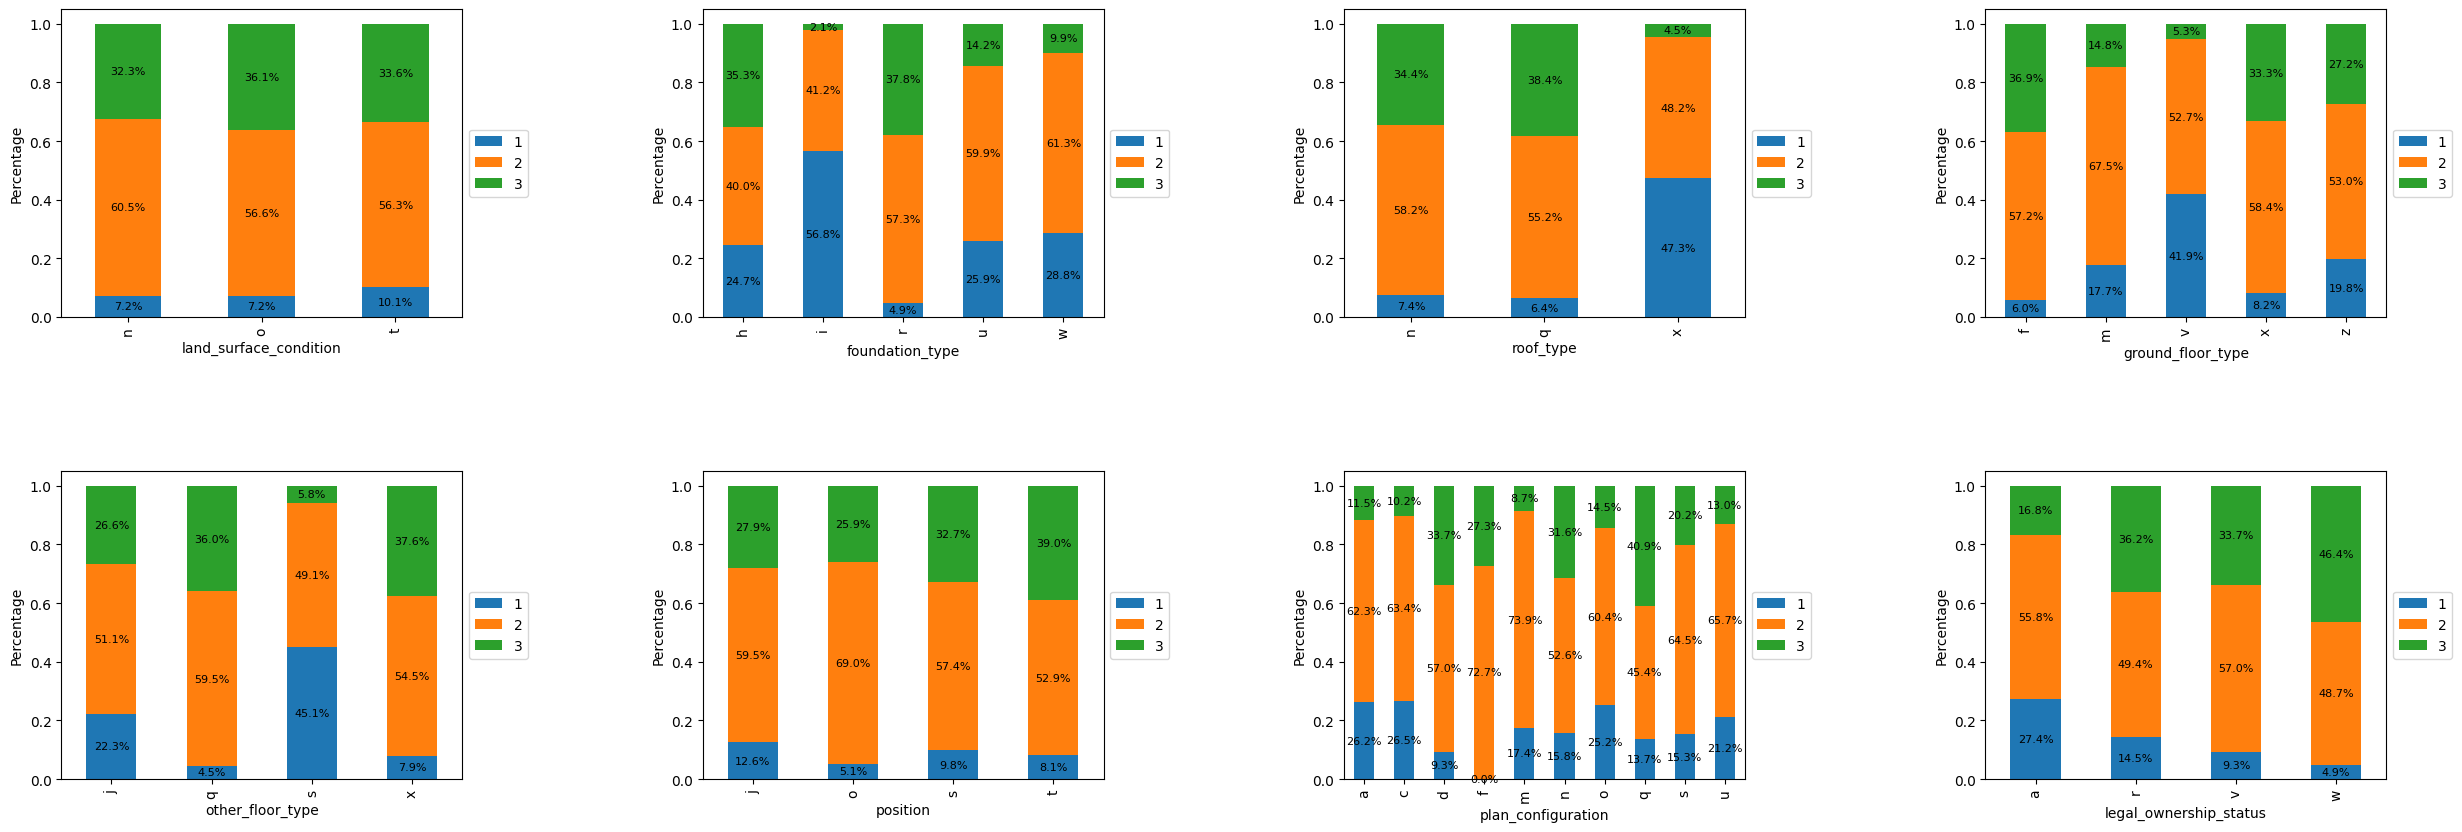

In [ ]:
categorical_vars = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
                    'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
target_var='damage_grade'

# Set the number of rows and columns for the plot grid
num_rows = 2
num_cols = 4

plot_correlation_cat_features(num_rows, num_cols, categorical_vars, target_var)

**From these features, the land_surface_condition seems to be the least correlated with the target, and all the others are correlated because of the change in percentages we can see.**

## Splitting the data between training and testing
Since the data contains 260601 rows, we divide it between 99% training and 1% for validation.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.drop('damage_grade', axis=1), df['damage_grade'], random_state=20, shuffle=True, test_size=0.01)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(257994, 39)
(2607, 39)
(257994,)
(2607,)


## Data Preprocessing
In order to feed the data to ML models, we need it to be numerical. So, we need to encode our categorical features.

As a first step, we identify the columns that are categorical. These have the type "object". We differentiate between binary and multi-categories variable to apply Label Encoding and One Hot Encoding accordingly

In [ ]:
column_names = list(df.drop('damage_grade', axis=1).columns)
multi_class_columns = [col for col in column_names if df[col].dtype=='object' and df[col].nunique()>2]
binary_columns = [col for col in column_names if df[col].dtype=='object' and df[col].nunique()==2]
num_columns = [col for col in column_names if df[col].dtype!='object']
print(f"Multi Class columns: {multi_class_columns}")
print(f"Binary columns: {binary_columns}")
print(f"Numerical columns: {num_columns}")

Multi Class columns: ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
Binary columns: []
Numerical columns: ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', '

**We see that none of our categorical variables is binary**

## Creating a Pipeline
We start by creating a pipeline that we call on all models that we want to test. 
For now the preprocessing steps include:
*  One Hot Encoding for the categorical variables
* Dropping the building_id and count_families features 
* Performing Minmax scaling. 

**Note:** We will apply these at first for all models we are testing, but later we optimize the preprocessing steps according to the best model we pick.

In [ ]:
def get_pipeline(model):
  pipeline = Pipeline([
      ('preprocessor', ColumnTransformer(
          transformers=[
              ('cat', OneHotEncoder(), multi_class_columns), 
              ('num', make_pipeline(
                    FunctionTransformer(lambda x: x.drop(['building_id', 'count_families'], axis=1)),
                    MinMaxScaler()
                ), num_columns),
          ]
      )),
      ('model', model)
  ])
  return pipeline

## Trying Multiple Models
We start by training multiple models and observing their cross validation scores on the training set. This would give us an idea about the models that have potential to perform well.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# define the scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score), 
           'weighted_f1': make_scorer(f1_score, average='weighted')}

models = [
    LogisticRegression(),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    LGBMClassifier(),
]

# Define the dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 score'])

# Loop over each model and evaluate its performance on the test set
for model in models:
    pipeline = get_pipeline(model)
    # compute the cross-validation scores
    cv_results = cross_validate(pipeline, X_train, y_train, cv=3, scoring=scoring)
    model_name = type(model).__name__
    acc = cv_results["test_accuracy"].mean()
    f1 = cv_results["test_weighted_f1"].mean()
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': acc,
        'F1 score': f1
    }, ignore_index=True)
    print(model)

# Print the results dataframe
results_df

LogisticRegression()
GaussianNB()
DecisionTreeClassifier()
RandomForestClassifier()
AdaBoostClassifier()
LGBMClassifier()


,Model,Accuracy,F1 score
0,LogisticRegression,0.590948,0.538746
1,GaussianNB,0.419068,0.339675
2,DecisionTreeClassifier,0.652690,0.653212
3,RandomForestClassifier,0.709575,0.703161
4,AdaBoostClassifier,0.645655,0.614060
5,LGBMClassifier,0.711598,0.701485


### Let us try **Neural Networks**
Neural networks are usually built with Keras. Now we will build one and then wrap it in a **sklearn keras classifier** so that we can have it as part of a pipeline to apply **cross_validate** and any other sklearn function on it.

In [ ]:
def get_neural_net():

  model = Sequential()
  model.add(Dense(128, input_dim=67, activation='relu')) #Input shape 67 because of the One Hot Encoding
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


neural_net = KerasClassifier(build_fn=get_neural_net, epochs=20, batch_size=1024)

pipeline = get_pipeline(neural_net)
cv_results = cross_validate(pipeline, X_train, y_train, cv=3, scoring=scoring)
acc = cv_results["test_accuracy"].mean()
f1 = cv_results["test_weighted_f1"].mean()
results_df = results_df.append({
        'Model': "Neural Network",
        'Accuracy': acc,
        'F1 score': f1
    }, ignore_index=True)

results_df

Epoch 1/20
168/168 [==============================] - 2s 6ms/step - loss: 0.8175 - accuracy: 0.5841
Epoch 2/20
168/168 [==============================] - 1s 6ms/step - loss: 0.7766 - accuracy: 0.6102
Epoch 3/20
168/168 [==============================] - 1s 6ms/step - loss: 0.7627 - accuracy: 0.6242
Epoch 4/20
168/168 [==============================] - 1s 6ms/step - loss: 0.7551 - accuracy: 0.6302
Epoch 5/20
168/168 [==============================] - 1s 6ms/step - loss: 0.7499 - accuracy: 0.6336
Epoch 6/20
168/168 [==============================] - 1s 6ms/step - loss: 0.7467 - accuracy: 0.6364
Epoch 7/20
168/168 [==============================] - 1s 6ms/step - loss: 0.7428 - accuracy: 0.6389
Epoch 8/20
168/168 [==============================] - 1s 6ms/step - loss: 0.7394 - accuracy: 0.6408
Epoch 9/20
168/168 [==============================] - 2s 10ms/step - loss: 0.7342 - accuracy: 0.6463
Epoch 10/20
168/168 [==============================] - 2s 9ms/step - loss: 0.7285 - accuracy: 0.651

,Model,Accuracy,F1 score
0,LogisticRegression,0.590948,0.538746
1,GaussianNB,0.419068,0.339675
2,DecisionTreeClassifier,0.652690,0.653212
3,RandomForestClassifier,0.709575,0.703161
4,AdaBoostClassifier,0.645655,0.614060
5,LGBMClassifier,0.711598,0.701485
6,Neural Network,0.665488,0.649036


* **We can see that the Neural Network did not perform too much well, it needs further tuning, but it requires too much time to tune, which is why we do not select it for later steps.**
* **We can see that LightGBM and RandomForestClassifier have the highest performance, but maybe the others with some optimization they can also perform well. In the next section, we will optimize the ensemble models: RFC, Adaboost, and LGBM. We do not optimize the Neural Network because it takes too much time to tune.**

## Random Forest Tuning
We tune the parameters of Random Forest with **RandomizedSearchCV** with a **CV=3** and 5 iterations because it takes too much time to finish one run.

In [ ]:
# Define the parameter space
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# Create a RandomForestClassifier object
rfc = get_pipeline(RandomForestClassifier())

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    random_state=42
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print(random_search.best_params_)


{'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': None, 'model__max_depth': 30}


We see the effect of the best parameters on the test set.

In [ ]:
# Fit the pipeline on the training data
rfc_pipeline = get_pipeline(RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_split=5 , min_samples_leaf =4 , max_features = None ))
rfc_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc_pipeline.predict(X_val)

#Evaluate 
report = classification_report(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
print(report)
print(f"Accuracy of RFC is: {acc}")

              precision    recall  f1-score   support

           1       0.67      0.48      0.56       246
           2       0.75      0.84      0.79      1490
           3       0.76      0.67      0.71       871

    accuracy                           0.75      2607
   macro avg       0.72      0.66      0.69      2607
weighted avg       0.75      0.75      0.74      2607

Accuracy of RFC is: 0.7472190257000384


## Adaboost Tuning
We tune the parameters of Adaboost with **RandomizedSearchCV** with a **CV=3** and 5 iterations because it takes too much time to finish one run.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# define the parameter space
param_dist = {
    'model__n_estimators': [50, 100, 200, 400],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5, 1.0],
    'model__algorithm': ['SAMME', 'SAMME.R']
}

# create an AdaBoostClassifier object
ada_clf = get_pipeline(AdaBoostClassifier())

# create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=ada_clf,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    random_state=42
)

# fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# print the best hyperparameters
print(random_search.best_params_)

{'model__n_estimators': 400, 'model__learning_rate': 0.5, 'model__algorithm': 'SAMME.R'}


We test the best Adaboost model on the test set.

In [ ]:
# Fit the pipeline on the training data
rfc_pipeline = get_pipeline(AdaBoostClassifier(n_estimators = 400,learning_rate=0.5, algorithm='SAMME.R'))
rfc_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc_pipeline.predict(X_val)

#Evaluate 
report = classification_report(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
print(report)
print(f"Accuracy of Adaboost is: {acc}")

              precision    recall  f1-score   support

           1       0.59      0.37      0.45       246
           2       0.67      0.84      0.75      1490
           3       0.69      0.46      0.55       871

    accuracy                           0.67      2607
   macro avg       0.65      0.56      0.58      2607
weighted avg       0.67      0.67      0.65      2607

Accuracy of Adaboost is: 0.6693517453011124


## LightGBM Tuning
We tune the parameters of Light GBM with **RandomizedSearchCV** with a **CV=3** and 10 iterations because it is faster than the others.

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# define the parameter space
param_dist = {
    'model__n_estimators': [350, 380, 400],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'model__max_bin': [85,90,95],
    'model__max_depth': [20, 30, 40],
    'model__num_leaves': [200, 230, 250]
}

# create a LGBMClassifier object
lgbm = get_pipeline(lgb.LGBMClassifier())

# create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=42
)

# fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# print the best hyperparameters
print(random_search.best_params_)

{'model__num_leaves': 200, 'model__n_estimators': 350, 'model__max_depth': 30, 'model__max_bin': 95, 'model__learning_rate': 0.1}


We test the best LGBM model against the test set.

In [ ]:
# Fit the pipeline on the training data
rfc_pipeline = get_pipeline(lgb.LGBMClassifier(n_estimators=350, learning_rate=0.1,max_bin=95, max_depth=30, num_leaves=200))
rfc_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc_pipeline.predict(X_val)

#Evaluate 
report = classification_report(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
print(report)
print(f"Accuracy of Light GBM is: {acc}")

              precision    recall  f1-score   support

           1       0.72      0.53      0.61       246
           2       0.76      0.85      0.80      1490
           3       0.76      0.66      0.70       871

    accuracy                           0.75      2607
   macro avg       0.75      0.68      0.70      2607
weighted avg       0.75      0.75      0.75      2607

Accuracy of Light GBM is: 0.7545070962792482


**We can see that LightGBM performed the best among the 3 tuned models, which is why, we will select it and optimize it even more.**

### Optimizing Preprocessing for LightGBM

Since LightGBM is performing the best, we optimize using **GridsearchCV** with cv = 5 the processing steps that should go with it. Of course to avoid leakage, we perform crossvalidation on the training data only. Notably, we need to test the following:
* One Hot Encoding vs Label Encoding for categorical variables
* Standard Scaling vs Minmax Scaling for numerical variables

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'preprocessor__cat': [OrdinalEncoder(), OneHotEncoder()],
    'preprocessor__num__minmaxscaler': [StandardScaler(), MinMaxScaler()],
}
pipeline = get_pipeline(LGBMClassifier())
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# fit the grid search to the training data
grid_search.fit(X_train, y_train)

# print the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'preprocessor__cat': OrdinalEncoder(), 'preprocessor__num__minmaxscaler': StandardScaler()}


**According to these results, we change the processing steps in our pipeline and then fit the model again with these settings. So we use Ordinal Encoder and Standard Scaler**

In [ ]:
def drop_columns(X):
    return X.drop(['building_id', 'count_families'], axis=1)

def get_pipeline(model):
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(), multi_class_columns), 
            ('num', Pipeline([
                ('dropper', FunctionTransformer(drop_columns)),
                ('scaler', StandardScaler())
            ]), num_columns),
        ]
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

In [ ]:
# Fit the pipeline on the training data
rfc_pipeline = get_pipeline(lgb.LGBMClassifier(n_estimators=350, learning_rate=0.1,max_bin=95, max_depth=30, num_leaves=200))
rfc_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc_pipeline.predict(X_val)

#Evaluate 
report = classification_report(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
print(report)
print(f"Accuracy of Light GBM is: {acc}")

              precision    recall  f1-score   support

           1       0.70      0.54      0.61       246
           2       0.76      0.86      0.81      1490
           3       0.78      0.67      0.72       871

    accuracy                           0.76      2607
   macro avg       0.75      0.69      0.71      2607
weighted avg       0.76      0.76      0.76      2607

Accuracy of Light GBM is: 0.7637130801687764


**We can see now how the performance increased on the test set!!!**

We save the pipeline for later use.

In [ ]:
import pickle

# save your fitted pipeline to a file
with open('rfc_pipeline.pkl', 'wb') as f:
    pickle.dump(rfc_pipeline, f)

## Dealing with Data Imbalance
We know from our EDA that the training data is imbalanced, as each of the 3 categories has a different number of samples. In this section, we will investigate if balancing the data can help.

**1. Random Undersampling:** 

We try to balance the training data with random undersampling. 

In [ ]:
#Undersample the data
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler()
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# Fit the pipeline on the training data
rfc_pipeline = get_pipeline(lgb.LGBMClassifier(n_estimators=350, learning_rate=0.1,max_bin=95, max_depth=30, num_leaves=200))
rfc_pipeline.fit(X_train_under, y_train_under)

# Predict on the test data
y_pred = rfc_pipeline.predict(X_val)

#Evaluate 
report = classification_report(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
print(report)
print(f"Accuracy of Light GBM with undersampling is: {acc}")

              precision    recall  f1-score   support

           1       0.41      0.85      0.55       246
           2       0.79      0.58      0.67      1490
           3       0.64      0.75      0.69       871

    accuracy                           0.66      2607
   macro avg       0.62      0.72      0.64      2607
weighted avg       0.71      0.66      0.66      2607

Accuracy of Light GBM with undersampling is: 0.6597621787495205


**We see that RandomUndersampling made the performance decrease, so we do not want to use it.**

**2. Random Oversampling:** 

We try to balance the training data with random oversampling. 

In [ ]:
#Oversample the data
from imblearn.over_sampling import RandomOverSampler

over = RandomOverSampler()
X_train_over, y_train_over = over.fit_resample(X_train, y_train)

# Fit the pipeline on the training data
rfc_pipeline = get_pipeline(lgb.LGBMClassifier(n_estimators=350, learning_rate=0.1,max_bin=95, max_depth=30, num_leaves=200))
rfc_pipeline.fit(X_train_over, y_train_over)

# Predict on the test data
y_pred = rfc_pipeline.predict(X_val)

#Evaluate 
report = classification_report(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
print(report)
print(f"Accuracy of Light GBM with overrsampling is: {acc}")

              precision    recall  f1-score   support

           1       0.49      0.80      0.61       246
           2       0.81      0.68      0.74      1490
           3       0.69      0.75      0.72       871

    accuracy                           0.72      2607
   macro avg       0.66      0.74      0.69      2607
weighted avg       0.74      0.72      0.72      2607

Accuracy of Light GBM with overrsampling is: 0.7153816647487533


**With oversampling the performance is better than with undersampling and this is expected because we are not throwing away some data, but adding the same data will result in overfitting, which is why the performance decreased.**

**3. Cost Sensitive Training:** 

Instead of changing the dataset distribution, we train the model to recognize this distribution by performing cost sensitive training, where the loss gives more penalty when the miscalssification happens on a minority class.

In [ ]:
# Fit the pipeline on the training data
rfc_pipeline = get_pipeline(lgb.LGBMClassifier(n_estimators=350, learning_rate=0.1,max_bin=95, max_depth=30, num_leaves=200, class_weight={1:0.5, 2:0.25, 3:0.3}))
rfc_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc_pipeline.predict(X_val)

#Evaluate 
report = classification_report(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
print(report)
print(f"Accuracy of Light GBM with overrsampling is: {acc}")

              precision    recall  f1-score   support

           1       0.61      0.67      0.64       246
           2       0.78      0.80      0.79      1490
           3       0.75      0.69      0.72       871

    accuracy                           0.75      2607
   macro avg       0.71      0.72      0.72      2607
weighted avg       0.75      0.75      0.75      2607

Accuracy of Light GBM with overrsampling is: 0.7514384349827388


**Cost sensitive training performed better than balancing, but not better than the original system. Probably it needs further fine tuning in terms of class weights. Note that when we used class_weight='balanced', the accuracy was 71.23% which is why we decided to play with the weights**

## Stacking
We stack 3 models to investigate if stacking can help us. The models we stack are **LGBM, RandomForest**, and **Adaboost**, and we use **Logistic Regression** as a meta learner.

In [ ]:
# Create the three base models
lgbm_model = lgb.LGBMClassifier(n_estimators=350, learning_rate=0.1,max_bin=95, max_depth=30, num_leaves=200)
rf_model = RandomForestClassifier()
ada_model = AdaBoostClassifier()

# Create the logistic regression meta-model
logreg_model = LogisticRegression()

# Create the stacking classifier
stacked_model = StackingClassifier(
    estimators=[('lgbm', lgbm_model), ('rf', rf_model), ('ada', ada_model)],
    final_estimator=logreg_model
)

# Fit the stacking classifier on the training data
stacked_pipe = get_pipeline(stacked_model)
stacked_pipe.fit(X_train, y_train)

# Evaluate the performance of the stacking classifier on the test data
y_pred = stacked_pipe.predict(X_val)

report = classification_report(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
print(report)
print(f"Accuracy of RFC is: {acc}")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           1       0.72      0.52      0.61       246
           2       0.76      0.86      0.81      1490
           3       0.78      0.67      0.72       871

    accuracy                           0.77      2607
   macro avg       0.75      0.69      0.71      2607
weighted avg       0.77      0.77      0.76      2607

Accuracy of RFC is: 0.7652474108170311


**We can see that the performance increases!! Which highlights the importance of stacking!**

## Explainable Model
Now instead of having a model that just predict damages, we need a model to give us the reasoning behind the prediction as well. Which is why we use a library called SHAP. 
SHAP is a well known library in explainable AI, and it has many features. In this project we liked to investigate it a little to understand how the model is reasoning to give us predictions.

First we install and import shap

In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.9 MB/s eta 0:00:00


We define a tree explainer and we give it the LGBM model that we tuned earlier. This explainer will be responsible to give global and local explanations.

#### Global Explanation
The goal of the global explanation is to tell in general the model is paying attention to which features and how each of them is correlated with each class of the prediction

In [ ]:
explainer = shap.TreeExplainer(rfc_pipeline.named_steps['model'])
processing_pipe = rfc_pipeline.named_steps['preprocessor']
processing_pipe.fit(X_train)
X_val_explainable = processing_pipe.transform(X_val)
shap_values = explainer.shap_values(X_val_explainable)

In [ ]:
X_val_explainable = pd.DataFrame(X_val_explainable, columns=(multi_class_columns+num_columns))

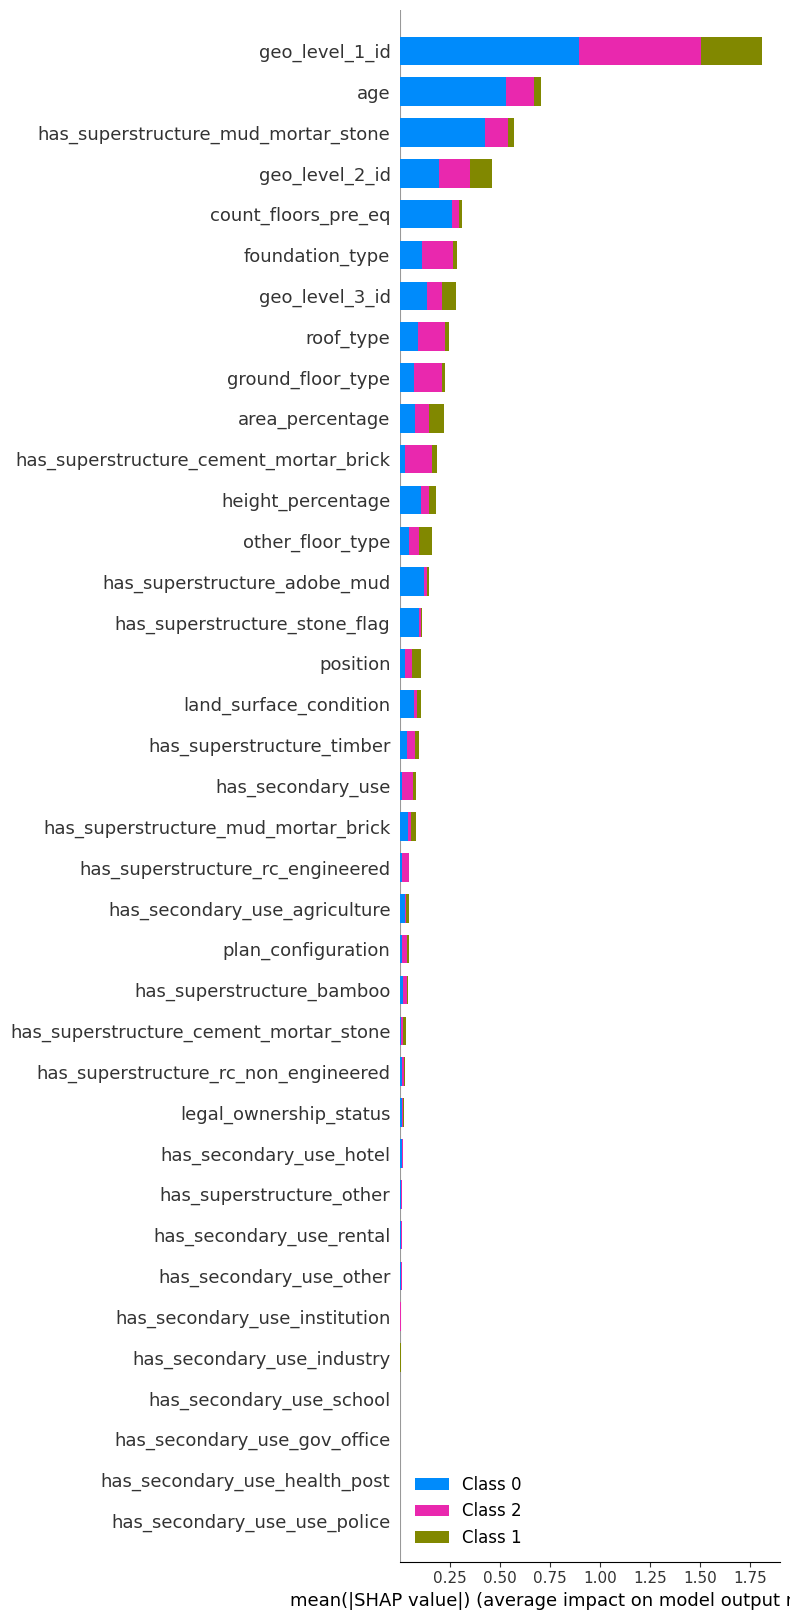

In [ ]:
# Visualize feature importances using a summary plot
shap.summary_plot(shap_values, X_val_explainable, max_display=40)

**We can see that the most important feature here is the geo_level_id which reflects the location of the house and this is very logical as the location will impact the level of damage if it is near the origin of the earthquake. We can see also other important features like the age of the building and the material used in the superstructure which also makes sense, because the damage should also depend on the strength of the building and its state.**


**On the other hand, we can see that the usage of the house for example is not an important feature, which is logical, since the goal of the usage will not affect the damage level.**

#### Local Explanation
The local explanation depends on one sample rather than on the entire dataset. 
So the SHAP explainer will explain for this sample, which features contributed more to the prediction than the others.

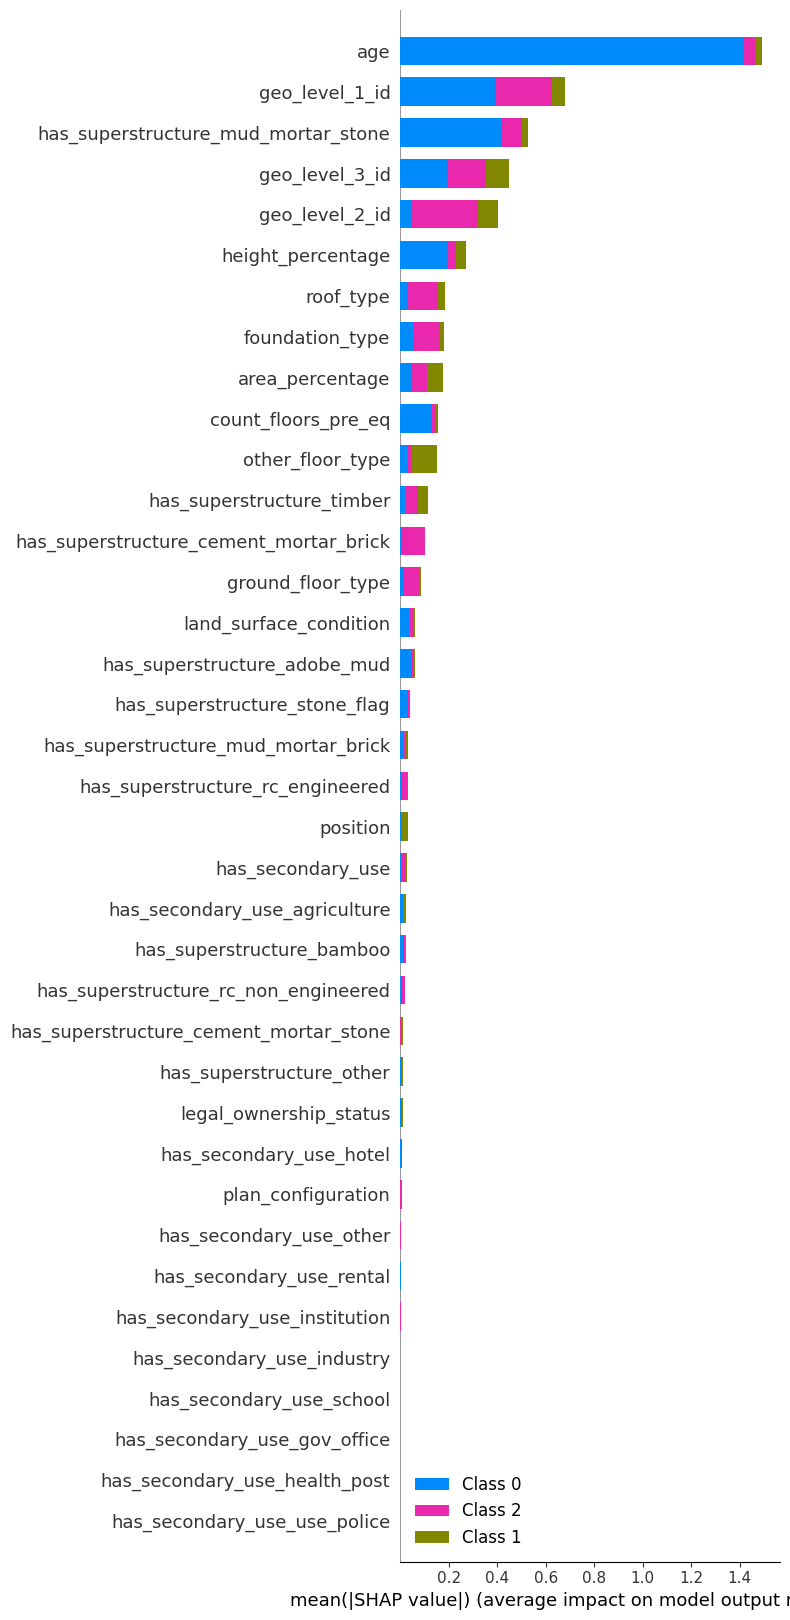

None

In [ ]:
# Choose an instance from your test data to explain
idx = 0  # Change this index to explain a different instance
x_instance = X_val_explainable.iloc[idx, :].values.reshape(1,-1)

# Generate SHAP values for the chosen instance
shap_values_instance = explainer.shap_values(x_instance)

fig_summary = shap.summary_plot(shap_values_instance, x_instance, feature_names=X_val_explainable.columns, max_display=40)

display(fig_summary)

**With the same logic as before we can see how each feature in this sample affected the prediction, and what we should notice is that the local explanations are different than the global explanations that we observed earlier on, and this is because each sample is unique, and depending on the values of the features in each sample, the model will decide to put more importance on specific features.**

## Submitting to DrivenData Competition
We used our best model to score the test set and submitted, and **we got in the first 10% among 6760 participants** &#127881;&#128515; Link for the competition: https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/ 

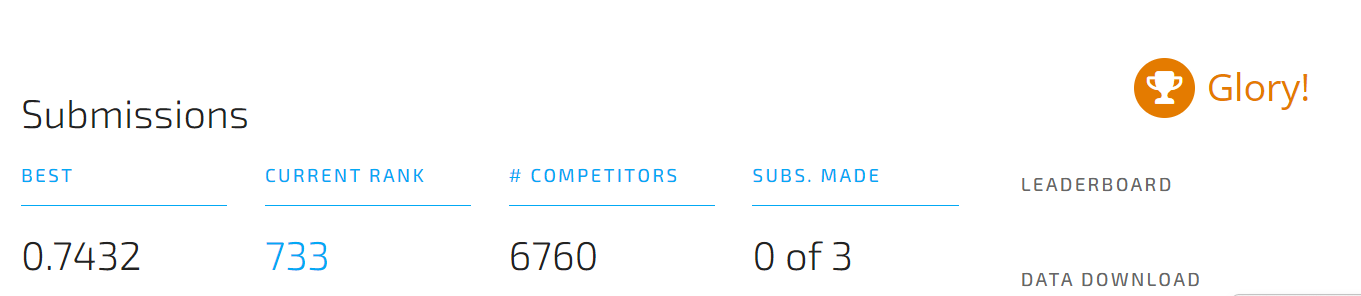

In [ ]:
df_test = pd.read_csv('test_values.csv')
predictions = stacked_pipe.predict(df_test)
submission = pd.DataFrame(
    {'building_id': df_test['building_id'].values, 'damage_grade': predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3


## Building a Website using Gradio
We finally deploy our model in a website using Gradio. Like that, a user can enter the features they want for a specific house and accordingly get a prediction, and you can use it on this link: 

https://huggingface.co/spaces/fouadtrad/MSBA315

**Screenshot from the website**
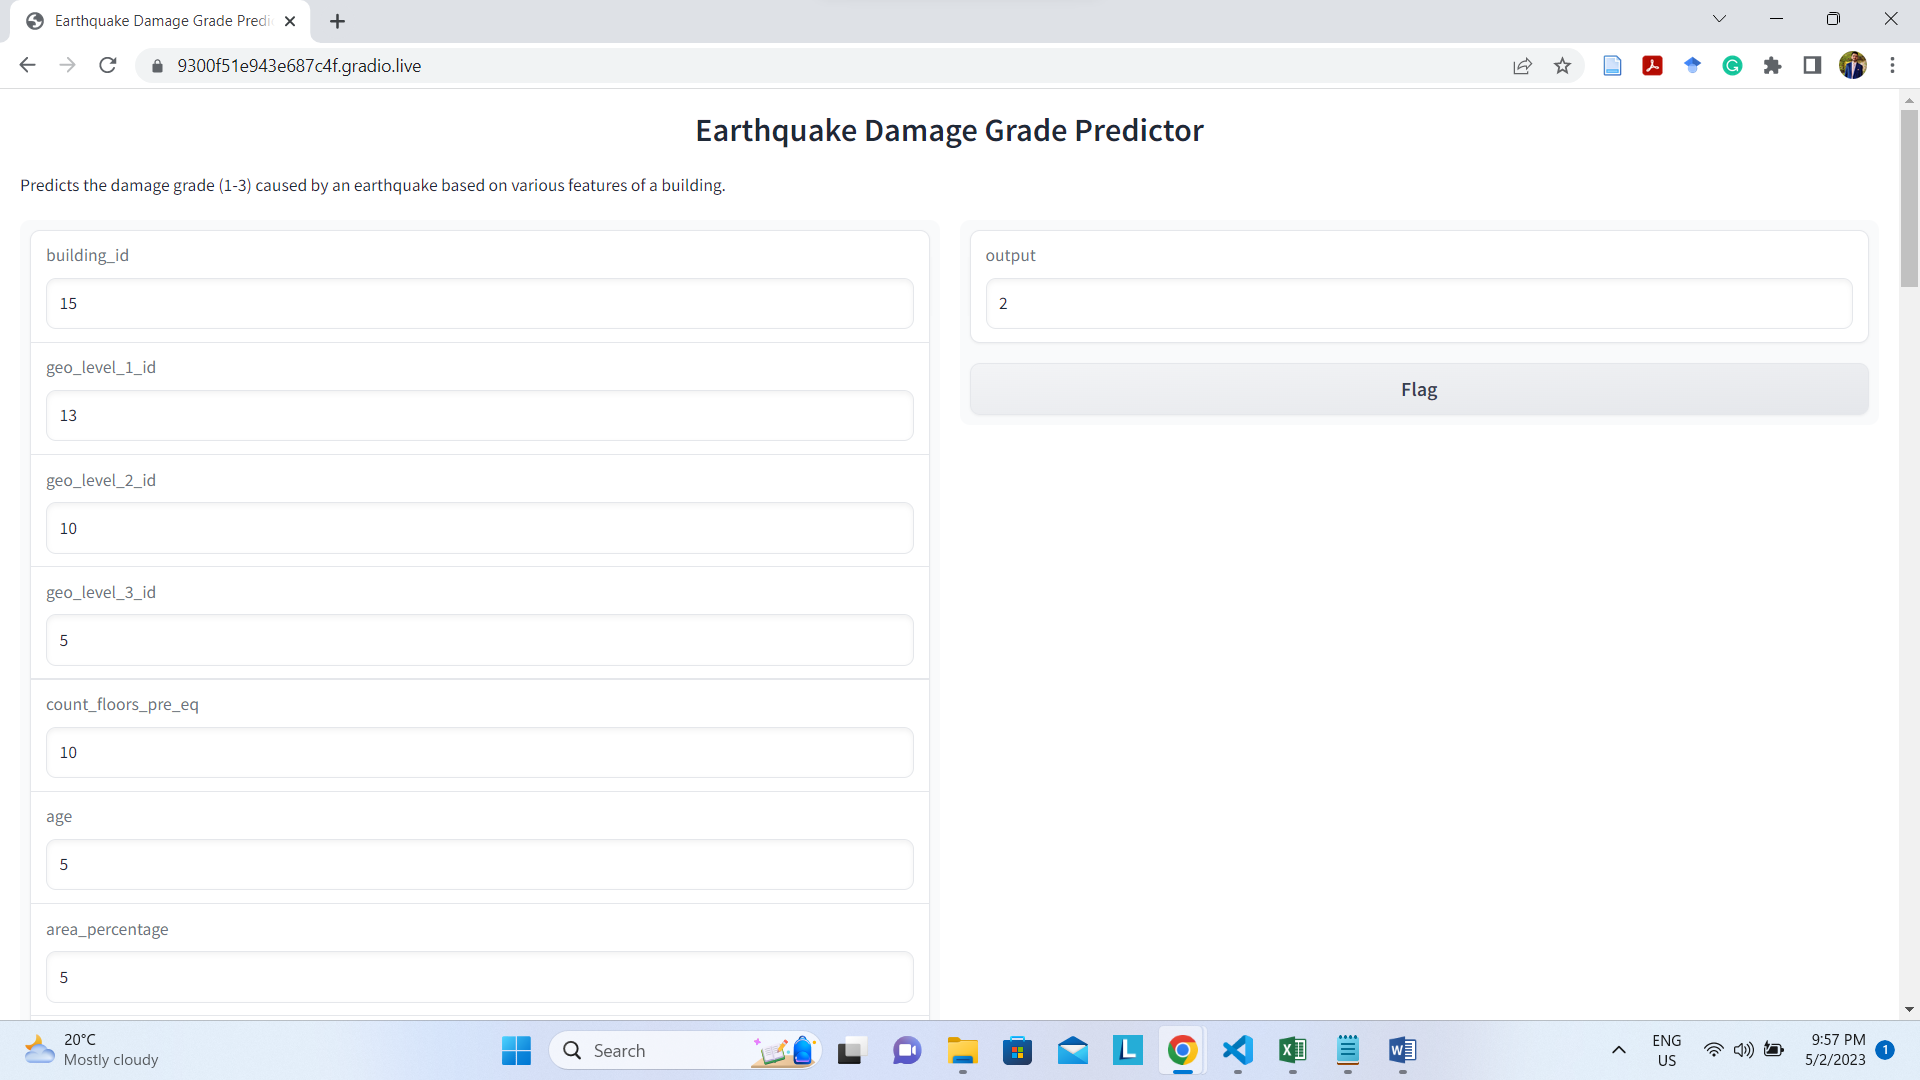